# Face Expression Recognition Project

In [1]:
# notebook imports

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image as im

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img

# get helper functions
# import helper_functions

In [2]:
# make model call backs

import os
save_path = 'model_experiments'

def create_model_checkpoint(model_name, save_path=save_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0, 
                                              save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=200,
                                                  restore_best_weights=True)

reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      patience=100,
                                                      verbose=1)

In [3]:
!wget https://raw.githubusercontent.com/benjaminogbonna/helper_codes/main/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir, view_random_image

--2022-05-04 23:49:49--  https://raw.githubusercontent.com/benjaminogbonna/helper_codes/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10642 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.39K  --.-KB/s    in 0s      

2022-05-04 23:49:49 (38.2 MB/s) - ‘helper_functions.py’ saved [10642/10642]



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [161]:
# get data

# face_data2 = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/face_expression/face_expression.zip'
# unzip_data(face_data2)

# train_dir = 'face_expression/train'
# validation_dir = 'face_expression/validation'

train_dir = 'data/face_expression/train'
validation_dir = 'data/face_expression/validation'

# Train model




In [162]:
TARGET_SIZE = (48, 48)
BATCH_SIZE = 128


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range = .1,
                                   height_shift_range = .1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=TARGET_SIZE,
                                                    color_mode="grayscale",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size=TARGET_SIZE,
                                                    color_mode="grayscale",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
# second model: improved
num_classes = 7 

model_1 = Sequential()

# 1 - Convolution
model_1.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# 2nd Convolution layer
model_1.add(Conv2D(128,(5,5), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# 3rd Convolution layer
model_1.add(Conv2D(512,(3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# 4th Convolution layer
model_1.add(Conv2D(512,(3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Flattening
model_1.add(Flatten())

# Fully connected layer 1st layer
model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_1.add(Dense(512))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(num_classes, activation='softmax', name='model_1'))


model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=.0001),
                metrics=['accuracy']
                )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [10]:
%%time

epochs = 100

callbacks_list = [create_model_checkpoint(model_name=model_1.name), early_stopping, reduce_plateau]


model_1_history = model_1.fit(train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - 53s 179ms/step - loss: 2.0604 - accuracy: 0.2090 - val_loss: 1.8387 - val_accuracy: 0.2597 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - 35s 154ms/step - loss: 1.9244 - accuracy: 0.2408 - val_loss: 1.8458 - val_accuracy: 0.2132 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - 38s 169ms/step - loss: 1.8780 - accuracy: 0.2523 - val_loss: 1.7761 - val_accuracy: 0.2902 - lr: 1.0000e-04
Epoch 4/100
225/225 [==============================] - 38s 170ms/step - loss: 1.8386 - accuracy: 0.2660 - val_loss: 1.6977 - val_accuracy: 0.3284 - lr: 1.0000e-04
Epoch 5/100
225/225 [==============================] - 38s 170ms/step - loss: 1.8012 - accuracy: 0.2845 - val_loss: 1.6683 - val_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 6/100
225/225 [==============================] - 34s 151ms/step - loss: 1.7630 - accuracy: 0.3015 - val_loss: 1.7266 - val_accuracy: 0.3504 - lr: 1.0000e-04
Epoch 7/100
225/225 [=

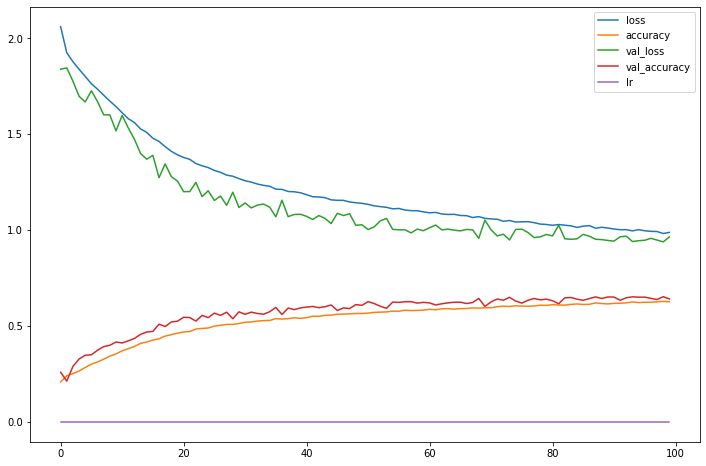

In [11]:
pd.DataFrame(model_1_history.history).plot(figsize=(12, 8))

In [12]:
model_1.evaluate(validation_generator)

56/56 [==============================] - 4s 62ms/step - loss: 0.9646 - accuracy: 0.6417


[0.9645597338676453, 0.6416643261909485]

In [14]:
saved_model = tf.keras.models.load_model('model_experiments/sequential/')
saved_model.evaluate(validation_generator)

56/56 [==============================] - 5s 83ms/step - loss: 0.9382 - accuracy: 0.6536


[0.9382252097129822, 0.653552234172821]

In [15]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model.h5'

saved_model.save(location)

In [ ]:
num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(7, activation='softmax'))


model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_2 = model_2.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=num_epoch,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


448/448 [==============================] - 21s 44ms/step - loss: 1.8332 - accuracy: 0.2371 - val_loss: 1.7713 - val_accuracy: 0.4171
Epoch 2/50
448/448 [==============================] - 19s 43ms/step - loss: 1.7905 - accuracy: 0.2631 - val_loss: 1.8324 - val_accuracy: 0.2321
Epoch 3/50
448/448 [==============================] - 19s 42ms/step - loss: 1.7555 - accuracy: 0.2762 - val_loss: 1.6715 - val_accuracy: 0.3831
Epoch 4/50
448/448 [==============================] - 19s 43ms/step - loss: 1.7030 - accuracy: 0.3083 - val_loss: 1.7097 - val_accuracy: 0.3301
Epoch 5/50
448/448 [==============================] - 19s 43ms/step - loss: 1.6702 - accuracy: 0.3301 - val_loss: 1.5363 - val_accuracy: 0.4085
Epoch 6/50
448/448 [==============================] - 20s 45ms/step - loss: 1.6335 - accuracy: 0.3533 - val_loss: 1.4871 - val_accuracy: 0.4138
Epoch 7/50
448/448 [==============================] - 19s 43ms/step - loss: 1.5902 - accuracy: 0.3747 - val_loss: 1.4264 - val_accuracy: 0.4573
Epo

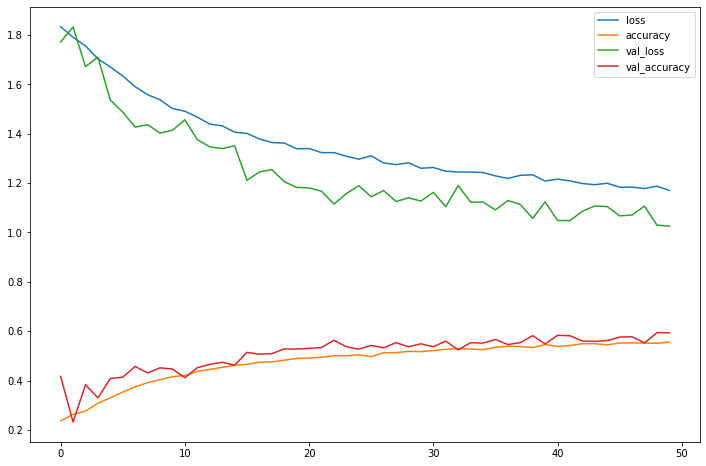

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(12, 8))

In [ ]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model_7.h5'

model_2.save(location)

# 3rd model

In [ ]:
# number of images to feed into the NN for every batch
batch_size = 128

pic_size = 48

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(train_dir,
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(validation_dir,
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/50
225/225 [==============================] - 37s 108ms/step - loss: 2.0517 - accuracy: 0.2309 - val_loss: 1.7310 - val_accuracy: 0.3119
Epoch 2/50
225/225 [==============================] - 24s 106ms/step - loss: 1.8346 - accuracy: 0.2959 - val_loss: 1.6593 - val_accuracy: 0.3581
Epoch 3/50
225/225 [==============================] - 23s 102ms/step - loss: 1.7349 - accuracy: 0.3395 - val_loss: 1.5815 - val_accuracy: 0.3882
Epoch 4/50
225/225 [==============================] - 23s 102ms/step - loss: 1.6606 - accuracy: 0.3656 - val_loss: 1.5587 - val_accuracy: 0.3986
Epoch 5/50
225/225 [==============================] - 23s 103ms/step - loss: 1.6013 - accuracy: 0.3873 - val_loss: 1.5218 - val_accuracy: 0.4162
Epoch 6/50
225/225 [==============================] - 23s 103ms/step - loss: 1.5428 - accuracy: 0.4081 - val_loss: 1.6067 - val_accuracy: 0.4045
Epoch 7/50
225/225 [==============================] - 23s 103ms/step - loss: 1.4941 - accuracy: 0.4298 - val_loss: 1.4567 - val_ac

In [ ]:
model_accuracy = model.evaluate(validation_generator)

model_accuracy

56/56 [==============================] - 3s 52ms/step - loss: 1.0208 - accuracy: 0.6499


[1.0208085775375366, 0.6498726010322571]

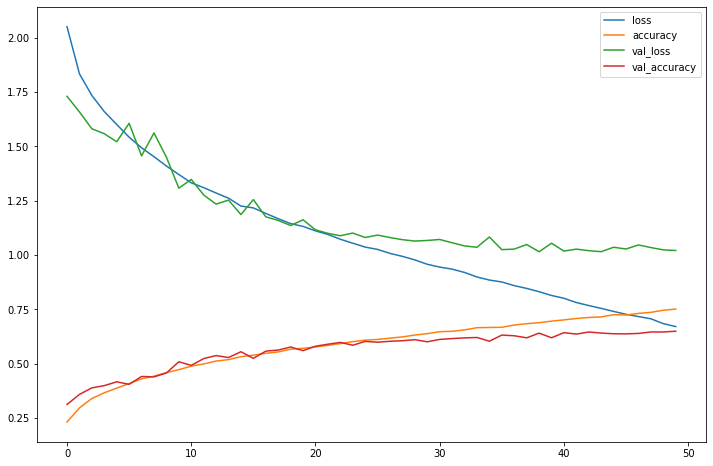

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8))

In [ ]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model_3.h5'

model.save(location)

In [2]:
model = tf.keras.models.load_model('model_3.h5')

# classes of face expression
emotion_list = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
haarcascade = 'haarcascade_frontalface_default.xml'

In [4]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    image = cv2.imread(filename)

    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(haarcascade)

    faces = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:    
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face = image[y:y + h, x:x + w]
        gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(gray, (48, 48)), -1), 0)
        
        return cropped_img

In [5]:
file = 'sample_predictions/image.jpg'
image = load_and_prep_image(file)

pred = model.predict(image)
emotion_list[int(np.argmax(pred))] 

'Happy'